In [4]:
from utils.DataInterface import DataInterface
from models.sSnomModel import sSnomModel

data_iface = DataInterface()

project_root = data_iface.find_project_root()
chen_data_path = project_root / "data/Chen2021"

data_iface.list_folder_contents(chen_data_path)


Project Root: /Users/lugarini/Documents/nano-optics-ml
Data Directory: /Users/lugarini/Documents/nano-optics-ml/data

Contents of the main data directory:
- .DS_Store (File)
- Chen2021 (Dir)
- NanoFTIR (Dir)


[PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/Au_nk.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/NGO_eff.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/LSAT_eff.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/CaF2_eff.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/GaAs_eff.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/STO_eff.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/SiO2_nk.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/article_main_data.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/CaF2_nk.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/chen_article_code_and_data_extraction.ipynb'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/data/Chen2021/STO_nk.csv'),
 PosixPath('/Users/lugarini/Documents/nano-optics-ml/dat

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pathlib import Path

# --- ASSUMING SnomModel IS IMPORTED OR PASTED HERE ---
# from snom_model import SnomModel 

class SnomWorkflow:
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        # Initialize Physics Model with your specific tip parameters
        self.model = sSnomModel(radius=50e-7, length=500e-7, g_factor=0.7 * np.exp(0.07 * 1j))
        
        # Simulation Constants
        self.t_osc = np.linspace(0, math.pi, 30)
        self.A = 68e-7 # Amplitude
        self.z_t = self.A * (1 - np.cos(self.t_osc)) # Tip motion
        self.harmonic = 2

    def _load_csv(self, filename):
        """Helper to load generic CSV data."""
        path = self.data_dir / filename
        if not path.exists():
            raise FileNotFoundError(f"Could not find {path}")
        return np.genfromtxt(path, delimiter=',')

    def process_material(self, name, freq_cutoff=None):
        """
        Loads data, calculates Epsilon (if needed), runs the FDM model,
        and returns a clean dictionary of arrays.
        """
        # 1. Load Data based on material quirks
        if name == 'CaF2':
            # CaF2 has signal in _eff and optical constants in _nk
            data_eff = self._load_csv('CaF2_eff.csv')
            data_nk = self._load_csv('CaF2_nk.csv')
            
            f = data_eff[:, 4]
            # Interp NK data to match signal frequencies
            n = np.interp(f, data_nk[:, 0], data_nk[:, 1])
            k = np.interp(f, data_nk[:, 0], data_nk[:, 2])
            eps = (n**2 - k**2) + 1j * (2*n*k)
            
            # Extract Experimental Signal
            s_exp = data_eff[:, 2] + 1j * data_eff[:, 3]
            
        else:
            # Standard Format (e.g., STO, SiO2, etc.)
            filename = f"{name}_eff.csv"
            data = self._load_csv(filename)
            
            # Columns: 0=Re(eps), 1=Im(eps), 2=Re(Sn), 3=Im(Sn), 4=Freq
            f = data[:, 4]
            eps = data[:, 0] + 1j * data[:, 1]
            s_exp = data[:, 2] + 1j * data[:, 3]

        # 2. Filter Frequencies (if requested)
        if freq_cutoff:
            mask = f < freq_cutoff
            f = f[mask]
            eps = eps[mask]
            s_exp = s_exp[mask]

        # 3. Calculate Model (Theoretical Sn)
        # Note: Your script applied a 0.25 * FFF correction factor
        fff = self.model.far_field_factor(f, eps)
        
        # Calculate base dipole signal (S_sample / S_ref)
        s_model_raw = self.model.calculate_signal(
            w=f, z=self.z_t, t=self.t_osc, 
            eps_sample=eps, n=self.harmonic, model='finite_2'
        )
        
        # Apply the far-field scaling from your original script
        s_model_final = 0.25 * fff * s_model_raw

        return {
            "name": name,
            "f": f,
            "eps": eps,
            "s_exp": s_exp,
            "s_model": s_model_final
        }

# --- PLOTTING FUNCTION ---

def recreate_figure_1c(results_dict):
    """
    Recreates the exact 2-row layout from the image.
    Row 1: Experimental Signal (Re/Im)
    Row 2: Dielectric Function (Epsilon 1/2)
    """
    materials = ['STO', 'SiO2', 'NGO', 'CaF2', 'LSAT']
    cols = len(materials)
    
    # Create grid: 2 Rows, 5 Columns
    fig, axes = plt.subplots(2, cols, figsize=(15, 6), sharex='col')
    
    # Color Scheme
    color_re = 'blue'  # Re(S) and Eps1
    color_im = 'red'   # Im(S) and Eps2
    
    for i, mat_name in enumerate(materials):
        if mat_name not in results_dict:
            continue
            
        data = results_dict[mat_name]
        ax_top = axes[0, i]
        ax_bot = axes[1, i]
        
        # --- TOP ROW: Signal Sn (Experimental) ---
        ax_top.plot(data['f'], np.real(data['s_exp']), color=color_re, label=r'Re($S_2^{exp}$)')
        ax_top.plot(data['f'], np.imag(data['s_exp']), color=color_im, label=r'Im($S_2^{exp}$)')
        
        # Titles and Formatting
        ax_top.set_title(mat_name, fontweight='bold', fontsize=12)
        ax_top.axhline(0, color='black', linewidth=0.5, linestyle='--')
        
        # Only show Y-label for the first column
        if i == 0:
            ax_top.set_ylabel(r'$S_2^{exp}$', fontsize=12)
        
        # Add legend only to the first plot to avoid clutter
        if i == 0:
            ax_top.legend(frameon=False, fontsize=8, loc='upper right')

        # --- BOTTOM ROW: Epsilon (Dielectric Function) ---
        ax_bot.plot(data['f'], np.real(data['eps']), color=color_re, label=r'$\epsilon_1$')
        ax_bot.plot(data['f'], np.imag(data['eps']), color=color_im, label=r'$\epsilon_2$')
        
        ax_bot.set_xlabel(r'Frequency (cm$^{-1}$)')
        ax_bot.axhline(0, color='black', linewidth=0.5, linestyle='--')
        
        if i == 0:
            ax_bot.set_ylabel(r'$\epsilon$', fontsize=12)
            ax_bot.legend(frameon=False, fontsize=8, loc='upper right')

    plt.tight_layout()
    return fig

Project Root: /Users/lugarini/Documents/nano-optics-ml
Data Directory: /Users/lugarini/Documents/nano-optics-ml/data

Contents of the main data directory:
- .DS_Store (File)
- Chen2021 (Dir)
- NanoFTIR (Dir)
Processing STO...
Processing SiO2...
Processing NGO...
Processing CaF2...
Processing LSAT...
Processing GaAs...


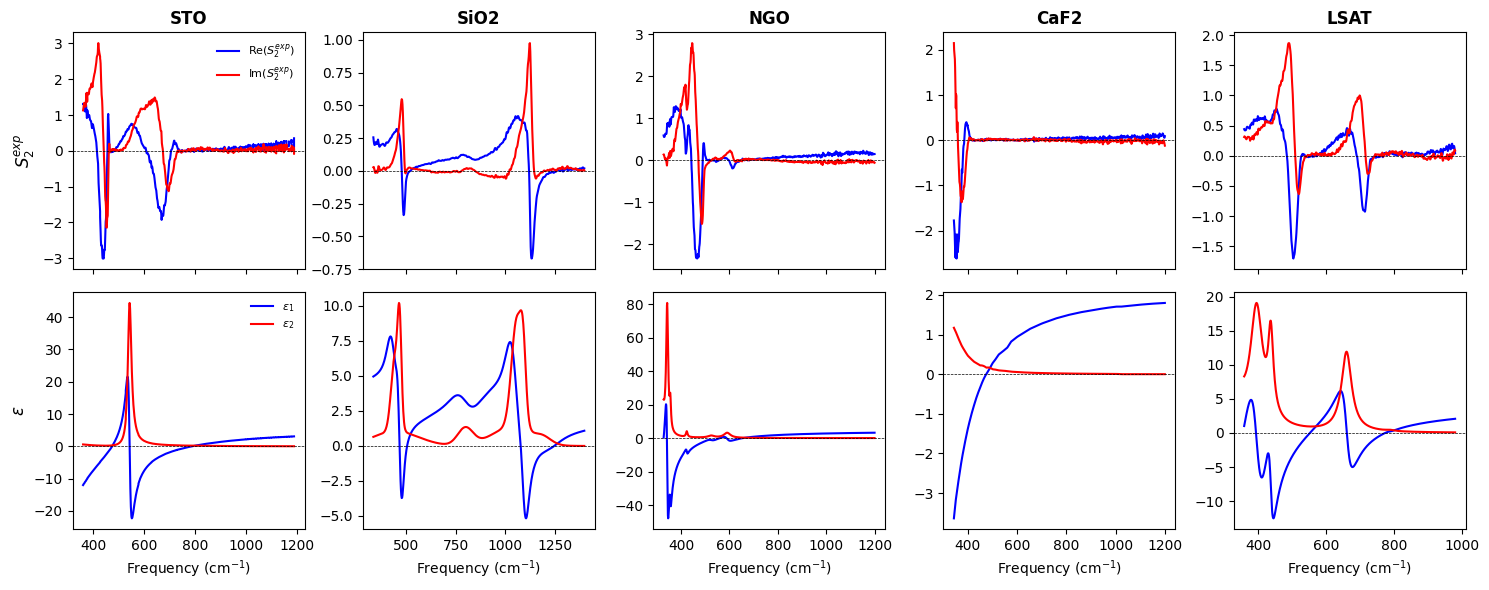

In [6]:
# 1. Setup Paths
from utils.DataInterface import DataInterface
data_iface = DataInterface()
project_root = data_iface.find_project_root()
data_path = project_root / "data/Chen2021"

# 2. Initialize Workflow
workflow = SnomWorkflow(chen_data_path)

# 3. Process All Materials
# Storing results in a dictionary for easy plotting access
processed_data = {}

# Define cutoffs based on your script (SiO2 goes up to 1400, others 800-1000)
material_configs = {
    'STO': 1200, 
    'SiO2': 1400, 
    'NGO': 1200, 
    'CaF2': 1200, 
    'LSAT': 1000,
    'GaAs': 1000 # Optional, not in image
}

for mat, cutoff in material_configs.items():
    try:
        print(f"Processing {mat}...")
        processed_data[mat] = workflow.process_material(mat, freq_cutoff=cutoff)
    except FileNotFoundError as e:
        print(e)

# 4. Generate the Plot
fig = recreate_figure_1c(processed_data)
plt.show()